🚀 STEP 5-A: POLICY PROBABILISTIC EVALUATION START

📊 확률 품질 지표 (정책 모델)
Brier Score : 0.0963
Log Loss    : 0.3323
AUC         : 0.7248


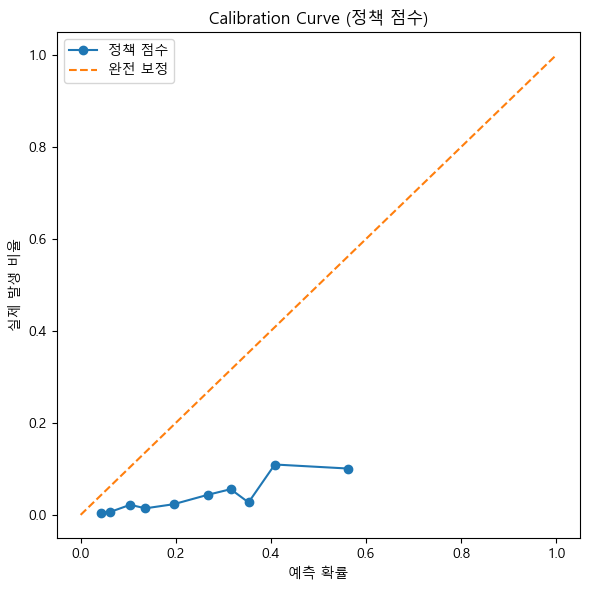


📊 집중 타겟팅 성능 (Lift)
        구간  대상 수  진성 쉬었음 비율(%)  Lift
0  Top 30%  2324          7.92  1.94
1  Top 20%  1549         10.52  2.58
2  Top 10%   774         10.08  2.47

💾 저장 완료: ../results/final/step5A_policy_evaluation.csv
🎉 STEP 5-A COMPLETE


In [ ]:
# ======================================================
# STEP 5-A: Policy Model Probabilistic Evaluation
# ======================================================
# - 타깃: 진성쉬었음
# - 목적: 정책 대상자 선별 성능 검증
# - CBM 사용 ❌
# ======================================================

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.metrics import brier_score_loss, log_loss, roc_auc_score
from sklearn.calibration import calibration_curve
from matplotlib import font_manager, rc
import platform
import warnings
warnings.filterwarnings("ignore")

# ------------------------------------------------------
# 한글 폰트
# ------------------------------------------------------
if platform.system() == "Windows":
    path = "C:/Windows/Fonts/malgun.ttf"
elif platform.system() == "Darwin":
    path = "/System/Library/Fonts/Supplemental/AppleGothic.ttf"
else:
    path = "/usr/share/fonts/truetype/nanum/NanumGothic.ttf"

font_name = font_manager.FontProperties(fname=path).get_name()
rc("font", family=font_name)

# ------------------------------------------------------
# 데이터 로드
# ------------------------------------------------------
print("=" * 70)
print("🚀 STEP 5-A: POLICY PROBABILISTIC EVALUATION START")
print("=" * 70)

PATH = "../results/final/merged_policy_analysis.csv"
df = pd.read_csv(PATH)

TARGET_COL = "진성쉬었음"
POLICY_PROB = "지원필요도점수"

for col in [TARGET_COL, POLICY_PROB]:
    if col not in df.columns:
        raise ValueError(f"필수 컬럼 누락: {col}")

y_true = df[TARGET_COL].astype(int).values
y_prob = np.clip(df[POLICY_PROB].values, 1e-15, 1 - 1e-15)

# ------------------------------------------------------
# 확률 품질
# ------------------------------------------------------
print("\n📊 확률 품질 지표 (정책 모델)")
print(f"Brier Score : {brier_score_loss(y_true, y_prob):.4f}")
print(f"Log Loss    : {log_loss(y_true, y_prob):.4f}")
print(f"AUC         : {roc_auc_score(y_true, y_prob):.4f}")

# ------------------------------------------------------
# Calibration Curve
# ------------------------------------------------------
pt, pp = calibration_curve(y_true, y_prob, n_bins=10, strategy="quantile")

plt.figure(figsize=(6, 6))
plt.plot(pp, pt, marker="o", label="정책 점수")
plt.plot([0, 1], [0, 1], "--", label="완전 보정")
plt.xlabel("예측 확률")
plt.ylabel("실제 발생 비율")
plt.title("Calibration Curve (정책 점수)")
plt.legend()
plt.tight_layout()
plt.show()

# ------------------------------------------------------
# Lift (Top-K)
# ------------------------------------------------------
print("\n📊 집중 타겟팅 성능 (Lift)")

base_rate = y_true.mean()
rows = []

for k in [0.30, 0.20, 0.10]:
    n = int(len(y_true) * k)
    idx = np.argsort(y_prob)[::-1][:n]
    top_rate = y_true[idx].mean()
    lift = top_rate / base_rate if base_rate > 0 else 0

    rows.append({
        "구간": f"Top {int(k*100)}%",
        "대상 수": n,
        "진성 쉬었음 비율(%)": round(top_rate * 100, 2),
        "Lift": round(lift, 2)
    })

table_policy = pd.DataFrame(rows)
print(table_policy)

# ------------------------------------------------------
# 저장
# ------------------------------------------------------
OUT_PATH = "../results/final/step5A_policy_evaluation.csv"
table_policy.to_csv(OUT_PATH, index=False, encoding="utf-8-sig")

print("\n💾 저장 완료:", OUT_PATH)
print("=" * 70)
print("🎉 STEP 5-A COMPLETE")
print("=" * 70)


from sklearn.metrics import roc_curve

# ------------------------------------------------------
# ROC Curve
# ------------------------------------------------------
fpr, tpr, thresholds = roc_curve(y_true, y_prob)
auc_score = roc_auc_score(y_true, y_prob)

plt.figure(figsize=(6, 6))
plt.plot(fpr, tpr, label=f"정책 점수 (AUC = {auc_score:.3f})")
plt.plot([0, 1], [0, 1], "--", color="gray", label="무작위 기준선")

plt.xlabel("False Positive Rate (1 - Specificity)")
plt.ylabel("True Positive Rate (Sensitivity)")
plt.title("ROC Curve (정책 점수)")
plt.legend()
plt.grid(alpha=0.3)
plt.tight_layout()
plt.show()
